# Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble  import RandomForestClassifier, AdaBoostClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import explained_variance_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot
from datetime import datetime, date
from sklearn.metrics import confusion_matrix, RocCurveDisplay
import xgboost as xgb
from matplotlib.patches import Patch
from datetime import datetime
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler 
from sklearn import ensemble,gaussian_process,linear_model,naive_bayes,neighbors,svm,tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, auc, classification_report, precision_recall_curve

# Load the dataset

In [2]:
train1 = pd.read_csv("train_month_1.csv") # for extra features
train2 = pd.read_csv("train_month_2.csv") # for extra features 
train3 = pd.read_csv("train_month_3_with_target.csv")
test1 = pd.read_csv("test_month_1.csv") # for extra features
test2 = pd.read_csv("test_month_2.csv") # for extra features
test3 = pd.read_csv("test_month_3.csv")

# Set current time

In [3]:
TT='2018-01'
TT=pd.to_datetime(TT,yearfirst=True,format='%Y-%m')

# Create extra features and export to csv file for EDA part in PowerBI

In [4]:
df = train3
df["customer_gender"] = df["customer_gender"].replace(1, 0).replace(2, 1)
 # balance difference last 2 months
df["bal_sav_diff_2"] = df["bal_savings_account"] - train2["bal_savings_account"]
df["bal_cur_diff_2"] = df["bal_current_account"] - train2["bal_current_account"]
 # balance difference last 1 months
df["bal_sav_diff_1"] = df["bal_savings_account"] - train1["bal_savings_account"]
df["bal_cur_diff_1"] = df["bal_current_account"] - train1["bal_current_account"]
# Age
df['Age']=(((TT)-(pd.to_datetime(df.customer_birth_date, yearfirst=True,format='%Y-%m')))/365.25).dt.days
# Time since when has the customer been a client for either bank or insurance products
df['Years_Since_all']=(((TT)-(pd.to_datetime(df.customer_since_all, yearfirst=True,format='%Y-%m')))/365.25).dt.days
# Time since when has the customer been a client for bank products
df['Years_Since_bank']=(((TT)-(pd.to_datetime(df.customer_since_bank, yearfirst=True,format='%Y-%m')))/365.25).dt.days
#df.to_csv(r'C:\Users\huudu\OneDrive\Desktop\advance analytics\full.csv',index=False)

# Preprocessing data

In [5]:
def load_data(file_path):
    # Read the csv 
    df = pd.read_csv(file_path)
    # Replace variables to proper dummy values
    df["customer_gender"] = df["customer_gender"].replace(1, 0).replace(2, 1)
    # additional feature: balance difference last 2 months
    df["bal_sav_diff_2"] = df["bal_savings_account"] - train1["bal_savings_account"]
    df["bal_cur_diff_2"] = df["bal_current_account"] - train1["bal_current_account"]
    # additional feature: balance difference last 1 months
    df["bal_sav_diff_1"] = df["bal_savings_account"] - train2["bal_savings_account"]
    df["bal_cur_diff_1"] = df["bal_current_account"] - train2["bal_current_account"]
    # Change the birth date to Age
    df['Age']=(((TT)-(pd.to_datetime(df.customer_birth_date, yearfirst=True,format='%Y-%m')))/365.25).dt.days
    # Change the Time to Year since when has the customer been a client for either bank or insurance products 
    df['Years_Since_all']=(((TT)-(pd.to_datetime(df.customer_since_all, yearfirst=True,format='%Y-%m')))/365.25).dt.days
    # Change the Time to Year since when has the customer been a client for bank products
    df['Years_Since_bank']=(((TT)-(pd.to_datetime(df.customer_since_bank, yearfirst=True,format='%Y-%m')))/365.25).dt.days
    # Fill value for columns having few missing values
    df['customer_occupation_code']= df["customer_occupation_code"].fillna(0)
    # Get dummies
    df[['customer_postal_code','customer_occupation_code'   ]]=df[['customer_postal_code','customer_occupation_code' ]].astype(int).astype(str)
    df = pd.get_dummies(df, columns=["customer_relationship","customer_children",'customer_postal_code','customer_occupation_code'], drop_first=True)
    # Drop unneccessary columns and columns having too much missing values (customer_education)
    df = df.drop(["client_id", "customer_education","customer_birth_date","customer_since_bank","customer_since_all"], axis=1)
    # Split train and test set and fill columns having missing values with its mode in train set (all columns are categorical)
    col_null = df.columns[df.isna().any()].tolist()
    X = df.drop(["target"],axis = 1)
    y = df["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    for col in col_null:
        X_train[col]=X_train[col].fillna(X_train[col].mode()[0])
        X_test[col]=X_test[col].fillna(X_train[col].mode()[0])
    # Dealing with imbalance dataset
    over = SMOTE(sampling_strategy=0.3, k_neighbors=3)
    under = RandomUnderSampler(sampling_strategy=0.5)
    X, y = over.fit_resample(X_train, y_train)
    X_train, y_train = under.fit_resample(X, y)

    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = load_data("train_month_3_with_target.csv")

# Feature Importance 

In [7]:
from sklearn import ensemble
from boruta import BorutaPy

def feature_selection(x_train, y_train,columns_order):
    '''
    Feature selection using Boruta
    '''
    rfc = ensemble.RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=10)
    boruta_selector = BorutaPy(rfc, n_estimators=1, verbose=2, random_state=1)
    boruta_selector.fit(np.array(x_train), np.array(y_train))  

    ### print results
    df= pd.DataFrame(columns_order,columns=['Features'])
    df['Ranking']=boruta_selector.ranking_

    print('Ranking: ',df.sort_values(by=['Ranking']))          
    print('No. of significant features: ', boruta_selector.n_features_) 

    # We pass the selector such that we can deal with transformations later
    return boruta_selector, df


In [8]:
columns_order=np.array(X_train.columns.tolist())

In [9]:
# Select features using Boruta
feature_selector, selected_features = feature_selection(X_train, y_train, columns_order)

# Apply feature selection
X_boruta= feature_selector.transform(np.array(X_train))
X_test_boruta = feature_selector.transform(np.array(X_test)) 

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	1087
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	1087
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	1087
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	1087
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	1087
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	1087
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	1087
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	1028
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	1028
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	1028
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	1028
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	36
Rejected: 	1051
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	36
Rejected: 	1051
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	35
Rejected: 	1051
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	35
Rejected: 	1051
Iteration: 	16 / 100
Confi

## Top 20 important features

In [10]:
selected_features.sort_values(by=['Ranking']).head(20)

,Features,Ranking
36,Years_Since_bank,1
31,bal_cur_diff_2,1
30,bal_sav_diff_2,1
29,customer_self_employed,1
28,customer_gender,1
26,visits_distinct_so,1
34,Age,1
23,bal_savings_account,1
35,Years_Since_all,1
21,bal_current_account,1


# Try number of models with selected important features

In [13]:


MLA = [

    #Ensemble Methods
    ensemble.AdaBoostClassifier(random_state=11),
    ensemble.BaggingClassifier(random_state=11),
    ensemble.GradientBoostingClassifier(random_state=11),
    ensemble.RandomForestClassifier(n_jobs = -1,random_state=11),
    xgb.XGBClassifier(random_state=42)
]

MLA_columns_boruta = []
MLA_compare_boruta = pd.DataFrame(columns = MLA_columns_boruta)
results_boruta=[]
row_index = 0
fitted_model_boruta = []
for alg in MLA:

    cv_results = cross_val_score(alg, X_boruta, y_train, cv=5, scoring='f1')
    results_boruta.append(cv_results)
    predicted = alg.fit(X_boruta, y_train).predict(X_test_boruta)
    #fp, tp, th = roc_curve(y_test, predicted)
    model = alg.fit(X_boruta, y_train)
    fitted_model_boruta.append(model)
    MLA_name = alg.__class__.__name__
    MLA_compare_boruta.loc[row_index, 'Name'] = MLA_name
    MLA_compare_boruta.loc[row_index, 'Train F1 Score'] = round(alg.score(X_boruta, y_train), 4)
    print("model:", alg,  " Train F1 Score: ", round(alg.score(X_boruta, y_train), 4))
    MLA_compare_boruta.loc[row_index, 'Test F1 Score'] = round(alg.score(X_test_boruta , y_test), 4)
    print("model: ",alg,  " Test F1 Score: ", round(alg.score(X_test_boruta , y_test), 4))
    #MLA_compare_boruta.loc[row_index, 'AUC'] = auc(fp, tp)  
    row_index+=1
    
MLA_compare_boruta.sort_values(by = ['Test F1 Score'], ascending = False, inplace = True)    
MLA_compare_boruta

model: AdaBoostClassifier(random_state=11)  Train F1 Score:  0.8726
model:  AdaBoostClassifier(random_state=11)  Test F1 Score:  0.9127
model: BaggingClassifier(random_state=11)  Train F1 Score:  0.9943
model:  BaggingClassifier(random_state=11)  Test F1 Score:  0.9434
model: GradientBoostingClassifier(random_state=11)  Train F1 Score:  0.8927
model:  GradientBoostingClassifier(random_state=11)  Test F1 Score:  0.9411
model: RandomForestClassifier(n_jobs=-1, random_state=11)  Train F1 Score:  1.0
model:  RandomForestClassifier(n_jobs=-1, random_state=11)  Test F1 Score:  0.9515


C:\Users\huudu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:12:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\huudu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:12:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\huudu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:12:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\huudu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:12:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\huudu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:12:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\huudu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:12:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:13:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42

,Name,Train F1 Score,Test F1 Score
4,XGBClassifier,0.9748,0.9652
3,RandomForestClassifier,1.0000,0.9515
1,BaggingClassifier,0.9943,0.9434
2,GradientBoostingClassifier,0.8927,0.9411
0,AdaBoostClassifier,0.8726,0.9127


## AUC Comparision

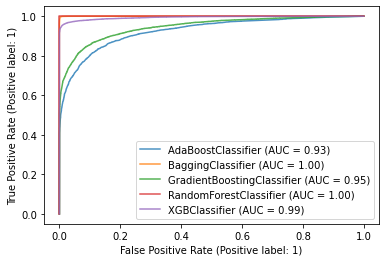

In [14]:
ax = plt.gca()
for mo in fitted_model_boruta:
    mo_disp = RocCurveDisplay.from_estimator(
    mo, X_boruta, y_train, ax=ax, alpha=0.8)
plt.show()

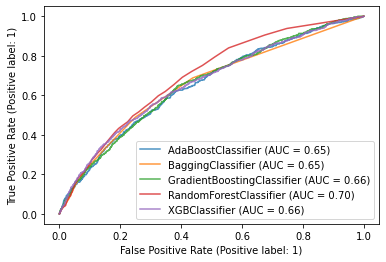

In [15]:
ax = plt.gca()
for mo in fitted_model_boruta:
    mo_disp = RocCurveDisplay.from_estimator(
    mo, X_test_boruta, y_test, ax=ax, alpha=0.8)
plt.show()

# Try the models with all features

In [16]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(random_state=11),
    ensemble.BaggingClassifier(random_state=11),
    ensemble.GradientBoostingClassifier(random_state=11),
    ensemble.RandomForestClassifier(n_jobs = -1,random_state=11),
    xgb.XGBClassifier(random_state=42)
]

MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)
results=[]
row_index = 0
fitted_model = []
for alg in MLA:
    cv_results = cross_val_score(alg, X_train, y_train, cv=5, scoring='f1')
    results.append(cv_results)
    predicted = alg.fit(X_train, y_train).predict(X_test)
    model = alg.fit(X_train, y_train)
    fitted_model.append(model)
    #fp, tp, th = roc_curve(y_test, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'Name'] = MLA_name
    MLA_compare.loc[row_index, 'Train F1 Score'] = round(alg.score(X_train, y_train), 4)
    print("model:", alg,  " Train F1 Score: ", round(alg.score(X_train, y_train), 4))
    MLA_compare.loc[row_index, 'Test F1 Score'] = round(alg.score(X_test , y_test), 4)
    print("model: ",alg,  " Test F1 Score: ", round(alg.score(X_test , y_test), 4))
    #MLA_compare.loc[row_index, 'AUC'] = auc(fp, tp)  
    row_index+=1
    
MLA_compare.sort_values(by = ['Test F1 Score'], ascending = False, inplace = True)    
MLA_compare

model: AdaBoostClassifier(random_state=11)  Train F1 Score:  0.891
model:  AdaBoostClassifier(random_state=11)  Test F1 Score:  0.9131
model: BaggingClassifier(random_state=11)  Train F1 Score:  0.9934
model:  BaggingClassifier(random_state=11)  Test F1 Score:  0.9372
model: GradientBoostingClassifier(random_state=11)  Train F1 Score:  0.8991
model:  GradientBoostingClassifier(random_state=11)  Test F1 Score:  0.9445
model: RandomForestClassifier(n_jobs=-1, random_state=11)  Train F1 Score:  1.0
model:  RandomForestClassifier(n_jobs=-1, random_state=11)  Test F1 Score:  0.9515


C:\Users\huudu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:22:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\huudu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\huudu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\huudu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\huudu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\huudu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:24:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42

,Name,Train F1 Score,Test F1 Score
4,XGBClassifier,0.9627,0.9596
3,RandomForestClassifier,1.0000,0.9515
2,GradientBoostingClassifier,0.8991,0.9445
1,BaggingClassifier,0.9934,0.9372
0,AdaBoostClassifier,0.8910,0.9131


## AUC Comparision 

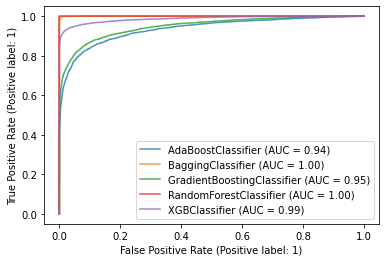

In [17]:
ax = plt.gca()
for mo in fitted_model:
    mo_disp = RocCurveDisplay.from_estimator(
    mo, X_train, y_train, ax=ax, alpha=0.8)
plt.show()

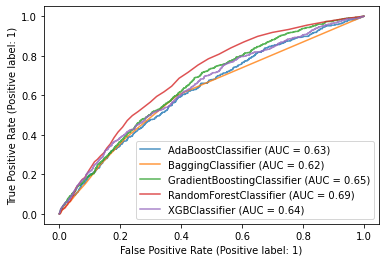

In [18]:
ax = plt.gca()
for mo in fitted_model:
    mo_disp = RocCurveDisplay.from_estimator(
    mo, X_test, y_test, ax=ax, alpha=0.8)
plt.show()